# Импорты библиотек

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as st
from scipy.stats import gaussian_kde
from datetime import datetime
import gradio as gr

# Чтение данных

In [2]:
df_path = "marketplace.csv"

df = pd.read_csv(df_path)
display(df.head())
df.info()

,user_id,platform_num,first_login,reg_dt,browser,first_buy,target,total_buy,total_return
0,user_000000,12,2025-03-22,2024-08-17,browser_00,2025-03-22,0.0,85.329559,0.0
1,user_000001,1,2025-05-05,2025-05-15,browser_01,2025-05-20,0.0,21.819124,0.0
2,user_000002,5,2025-01-19,2025-01-23,browser_02,2025-02-20,0.3,194.612980,485.0
3,user_000003,3,2025-03-15,2023-09-05,browser_02,NaN,0.0,138.780814,0.0
4,user_000004,1,2025-05-05,2025-05-14,browser_00,2025-05-11,0.0,16.334507,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25335 entries, 0 to 25334
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   user_id       25335 non-null  object 
 1   platform_num  25335 non-null  int64  
 2   first_login   25335 non-null  object 
 3   reg_dt        25331 non-null  object 
 4   browser       25335 non-null  object 
 5   first_buy     24361 non-null  object 
 6   target        25335 non-null  float64
 7   total_buy     25335 non-null  float64
 8   total_return  25335 non-null  float64
dtypes: float64(3), int64(1), object(5)
memory usage: 1.7+ MB


# Чистка данных

## Преобразование типов

In [3]:
df_cleaned = df.copy()

# df_cleaned = df_cleaned.astype({'reg_dt': int, 'first_buy': int, 'first_login': dt})

df_cleaned["reg_dt"] = pd.to_datetime(df_cleaned["reg_dt"], errors="coerce")
df_cleaned["first_buy"] = pd.to_datetime(df_cleaned["first_buy"], errors="coerce")
df_cleaned["first_login"] = pd.to_datetime(df_cleaned["first_login"], errors="coerce")

df_cleaned["user_id"] = df_cleaned["user_id"].apply(lambda x: int(x.strip("user_")))
df_cleaned["browser"] = df_cleaned["browser"].apply(lambda x: int(x.strip("browser_")))

## Заполнение нулей

In [4]:
df_cleaned["first_buy"].fillna(
    df_cleaned[["first_login", "reg_dt"]].max(axis=1), inplace=True
)

/tmp/ipython-input-1569350758.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_cleaned["first_buy"].fillna(


## Склеивание дублей и индексация по user_id

In [5]:
df_cleaned = df_cleaned.groupby(by="user_id").agg(
    {
        "platform_num": "min",
        "first_login": "min",
        "reg_dt": "min",
        "browser": "min",
        "first_buy": "min",
        "target": "mean",
        "total_buy": "sum",
        "total_return": "sum",
    }
)
df_cleaned.head()

,platform_num,first_login,reg_dt,browser,first_buy,target,total_buy,total_return
user_id,,,,,,,,
0,12,2025-03-22,2024-08-17,0,2025-03-22,0.0,85.329559,0.0
1,1,2025-05-05,2025-05-15,1,2025-05-20,0.0,21.819124,0.0
2,5,2025-01-19,2025-01-23,2,2025-02-20,0.3,194.612980,485.0
3,3,2025-03-15,2023-09-05,2,2025-03-15,0.0,138.780814,0.0
4,1,2025-05-05,2025-05-14,0,2025-05-11,0.0,16.334507,0.0


### Вспомогательные методы

In [6]:
def shapiro_check(dataset, col, alpha=0.05, n=3000):
    """
    Шапиро. Тест, является ли распределение СВ нормальным
    """
    checked_dataset = dataset[col] if n is None else dataset[col].sample(n=n)
    stat, pvalue = st.shapiro(checked_dataset)
    print("Шапиро")
    if pvalue > alpha:
        print(f"Данные {col} скорее всего распределены нормально\n")
    else:
        print(f"Данные {col} скорее всего распределены не нормально\n")


def kstest_check(dataset, col, alpha=0.05):
    """
    Колмогоров-Смирнов. Тест, является ли распределение СВ нормальным
    """
    arr = dataset[col]
    mu = arr.mean()
    sigma = arr.std(ddof=1)
    stat, pvalue = st.kstest(arr, "norm", args=(mu, sigma))

    print("Колмогоров-Смирнов")

    if pvalue > alpha:
        print(f"Данные {col} скорее всего распределены нормально\n")
    else:
        print(f"Данные {col} скорее всего распределены не нормально\n")


def iqr_filter(dataset, col):
    """
    Фильтр по межквартильному размаху
    """
    medi = dataset[col].median()
    Q1, Q3 = dataset[col].quantile([0.25, 0.75])
    IQR = Q3 - Q1

    bottom, top = medi - 1.5 * IQR, medi + 1.5 * IQR

    return dataset[(dataset[col] >= bottom) & (dataset[col] <= top)]

## Убрать выбросы по межквартильному размаху

In [7]:
df_cleaned_iqr = pd.DataFrame(data=df_cleaned)
df_cleaned_iqr = iqr_filter(df_cleaned_iqr, "total_buy")

shapiro_check(df_cleaned_iqr, "total_buy")
kstest_check(df_cleaned_iqr, "total_buy")
shapiro_check(df_cleaned_iqr, "total_return")
kstest_check(df_cleaned_iqr, "total_return")

Шапиро
Данные total_buy скорее всего распределены не нормально

Колмогоров-Смирнов
Данные total_buy скорее всего распределены не нормально

Шапиро
Данные total_return скорее всего распределены не нормально

Колмогоров-Смирнов
Данные total_return скорее всего распределены не нормально



## Убрать выбросы по 99-ому процентилю

In [8]:
q99 = df_cleaned["total_buy"].quantile(0.99)
df_q99_filtered = df_cleaned[df_cleaned["total_buy"] < q99]
df_q99_filtered = df_q99_filtered.drop(
    [383]
)  # ручная чистка выброса, не отсечённого процентилем

shapiro_check(df_q99_filtered, "total_buy")
kstest_check(df_q99_filtered, "total_buy")
shapiro_check(df_q99_filtered, "total_return")
kstest_check(df_q99_filtered, "total_return")

Шапиро
Данные total_buy скорее всего распределены не нормально

Колмогоров-Смирнов
Данные total_buy скорее всего распределены не нормально

Шапиро
Данные total_return скорее всего распределены не нормально

Колмогоров-Смирнов
Данные total_return скорее всего распределены не нормально



In [9]:
print("С фильтром по межквартильному размаху")
display(df_cleaned_iqr.describe())
print("С фильтром по 99-ому процентилю")
display(df_q99_filtered.describe())

С фильтром по межквартильному размаху


,platform_num,first_login,reg_dt,browser,first_buy,target,total_buy,total_return
count,20439.000000,20439,20439,20439.000000,20439,20439.000000,20439.000000,20439.000000
mean,4.730760,2025-03-18 12:07:04.834874368,2025-01-07 09:59:42.034346240,3.380841,2025-03-19 19:45:14.398943232,0.002579,63.771364,20.453601
min,1.000000,2024-09-21 00:00:00,2022-10-11 00:00:00,0.000000,2023-08-12 00:00:00,-3.428557,0.000000,0.000000
25%,1.000000,2025-02-11 00:00:00,2024-12-05 00:00:00,2.000000,2025-02-16 00:00:00,0.000000,15.801008,0.000000
50%,3.000000,2025-03-24 00:00:00,2025-03-02 00:00:00,2.000000,2025-03-27 00:00:00,0.000000,34.464635,0.000000
75%,5.000000,2025-04-30 00:00:00,2025-04-25 00:00:00,3.000000,2025-05-07 00:00:00,0.000000,86.964551,0.000000
max,194.000000,2025-07-26 00:00:00,2025-07-26 00:00:00,30.000000,2025-07-26 00:00:00,0.300000,329.032877,30602.033000
std,7.341859,NaN,NaN,3.593518,NaN,0.207371,71.620197,242.549226


С фильтром по 99-ому процентилю


,platform_num,first_login,reg_dt,browser,first_buy,target,total_buy,total_return
count,25076.000000,25076,25076,25076.000000,25076,25076.000000,25076.000000,25076.000000
mean,6.174031,2025-03-14 10:44:11.906205184,2024-12-09 04:32:35.910033408,3.391051,2025-03-14 01:06:19.582070272,0.002013,450.724607,160.044935
min,1.000000,2024-09-21 00:00:00,2022-10-11 00:00:00,0.000000,2023-08-08 00:00:00,-3.428557,0.000000,0.000000
25%,2.000000,2025-02-08 00:00:00,2024-10-17 00:00:00,2.000000,2025-02-14 00:00:00,0.000000,19.167307,0.000000
50%,3.000000,2025-03-23 00:00:00,2025-02-18 00:00:00,2.000000,2025-03-26 00:00:00,0.000000,51.904239,0.000000
75%,6.000000,2025-04-25 00:00:00,2025-04-19 00:00:00,3.000000,2025-05-02 00:00:00,0.000000,195.037597,0.000000
max,647.000000,2025-07-26 00:00:00,2025-07-26 00:00:00,30.000000,2025-07-26 00:00:00,0.300000,15998.649504,18782.000000
std,14.570548,NaN,NaN,3.570877,NaN,0.246701,1462.072962,776.399030


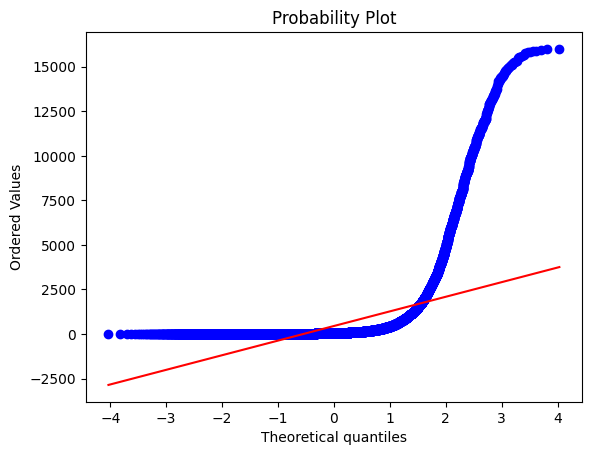

In [10]:
st.probplot(df_q99_filtered["total_buy"], plot=plt)

plt.show()

### Остановимся на фильтре по 99-процентилю, как довольно точному, но при этом с меньшим обрезанием покупателей с большой, но реалистичной суммой покупок и возвратов.

## Проверим распределение данных по датам.

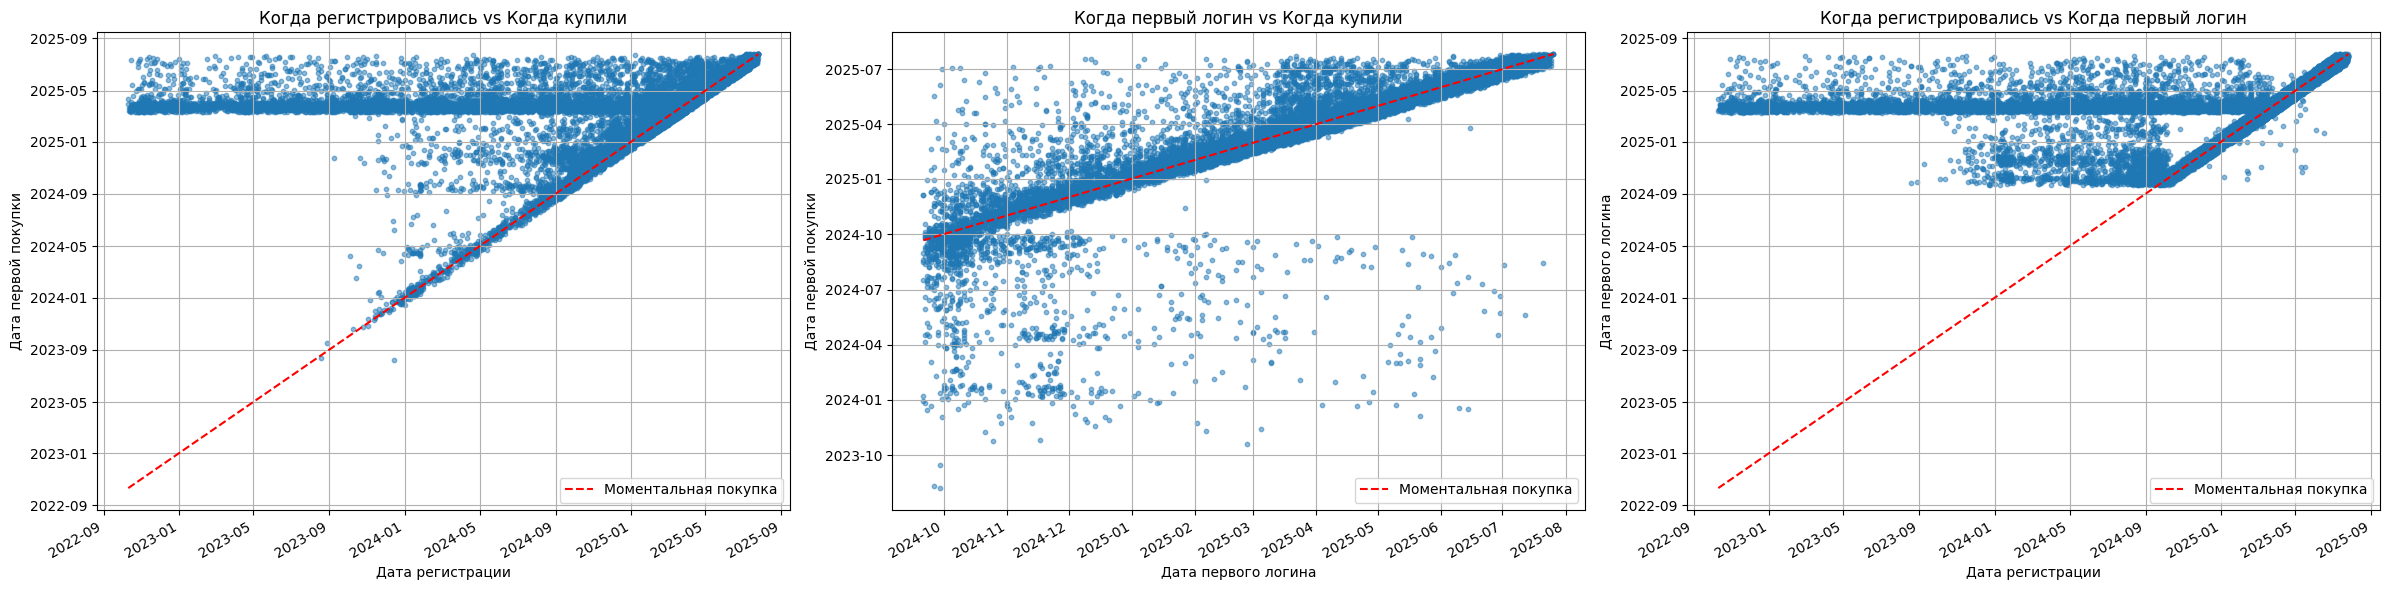

In [11]:
df_enriched = df_q99_filtered.copy()

# Построим для этого графики попарно
fig, axes = plt.subplots(1, 3, figsize=(24, 6))

# --- Первый график ---
# Строим график зависимости дат регистрации и дат первой покупки
axes[0].scatter(df_enriched["reg_dt"], df_enriched["first_buy"], alpha=0.5, s=10)

# Добавляем линию "мгновенной покупки" (где X=Y), чтобы видеть задержку
min_date = df_enriched["reg_dt"].min()
max_date = df_enriched["first_buy"].max()
axes[0].plot(
    [min_date, max_date],
    [min_date, max_date],
    color="red",
    linestyle="--",
    label="Моментальная покупка",
)

axes[0].set_title("Когда регистрировались vs Когда купили")
axes[0].set_xlabel("Дата регистрации")
axes[0].set_ylabel("Дата первой покупки")
axes[0].legend()
axes[0].grid(True)

# --- Второй график ---
# Строим график зависимости дат первого логина и дат первой покупки
axes[1].scatter(df_enriched["first_login"], df_enriched["first_buy"], alpha=0.5, s=10)

# Добавляем линию "мгновенной покупки" (где X=Y), чтобы видеть задержку
min_date = df_enriched["first_login"].min()
max_date = df_enriched["first_buy"].max()
axes[1].plot(
    [min_date, max_date],
    [min_date, max_date],
    color="red",
    linestyle="--",
    label="Моментальная покупка",
)

axes[1].set_title("Когда первый логин vs Когда купили")
axes[1].set_xlabel("Дата первого логина")
axes[1].set_ylabel("Дата первой покупки")
axes[1].legend()
axes[1].grid(True)


# --- Третий график ---
# Строим график зависимости дат регистрации и дат первого логина
axes[2].scatter(df_enriched["reg_dt"], df_enriched["first_login"], alpha=0.5, s=10)

# Добавляем линию "мгновенной покупки" (где X=Y), чтобы видеть задержку
min_date = df_enriched["reg_dt"].min()
max_date = df_enriched["first_login"].max()
axes[2].plot(
    [min_date, max_date],
    [min_date, max_date],
    color="red",
    linestyle="--",
    label="Моментальная покупка",
)

axes[2].set_title("Когда регистрировались vs Когда первый логин")
axes[2].set_xlabel("Дата регистрации")
axes[2].set_ylabel("Дата первого логина")
axes[2].legend()
axes[2].grid(True)


fig.autofmt_xdate()
plt.tight_layout()
plt.show()

Видим аномальные отклонения от предсказуемой красной линии, есть объёмная группа юзеров, что регестрировались на протяжении всего периода, но покупки совершали в марте-апреле 2025.   

В ходе анализа было выявлено и подтверждено, что данные с большой разницей между регистрацией и активностью дней являются техническим артефактом (сбоем БД или склеиванием двух БД).   

**Для чистоты моделирования эти записи (8 553 строки, 34.1% от выборки) были исключены.**

Дата First_buy для этой части данных, вероятней всего, была проставлена датой загрузки их загрузки в общую базу, т.к. эти пользователи зарегистривались 1-2-3 года назад, но первый логин и покупка были в марте-апреле 2025.   
В связи с невозможностью восстановить корректную дату (и по факту больших накопленных сумм покупок) оставлять эти данные опасно, они перетянут на себя всё внимание."

Исключим эти данные, сделав очистку по более 20 дней разницы между датами регистрации и покупки-логина (диапазон 20-25 визуально по графикам сверху самый предпочтительный)

In [12]:
condition_1 = (df_q99_filtered["first_buy"] - df_q99_filtered["reg_dt"]).dt.days > 20
df_q99_filtered = df_q99_filtered[~condition_1]
condition_2 = (df_q99_filtered["first_login"] - df_q99_filtered["reg_dt"]).dt.days > 20
df_q99_filtered = df_q99_filtered[~condition_2]
display(df_q99_filtered.describe())

,platform_num,first_login,reg_dt,browser,first_buy,target,total_buy,total_return
count,16523.000000,16523,16523,16523.000000,16523,16523.000000,16523.000000,16523.000000
mean,5.360830,2025-03-23 02:04:27.118562048,2025-03-23 06:28:52.130968832,3.430007,2025-03-24 04:36:47.541003520,0.002861,276.156966,86.269650
min,1.000000,2024-09-22 00:00:00,2024-09-04 00:00:00,0.000000,2024-08-21 00:00:00,-3.428557,0.000000,0.000000
25%,1.000000,2025-02-10 00:00:00,2025-02-10 00:00:00,2.000000,2025-02-12 00:00:00,0.000000,17.317609,0.000000
50%,2.000000,2025-03-26 00:00:00,2025-03-26 00:00:00,2.000000,2025-03-27 00:00:00,0.000000,40.930942,0.000000
75%,5.000000,2025-05-10 00:00:00,2025-05-10 12:00:00,3.000000,2025-05-11 00:00:00,0.000000,122.474094,0.000000
max,391.000000,2025-07-26 00:00:00,2025-07-26 00:00:00,30.000000,2025-07-26 00:00:00,0.300000,15998.649504,13067.956000
std,13.021972,NaN,NaN,3.574681,NaN,0.230128,1040.471804,477.992704


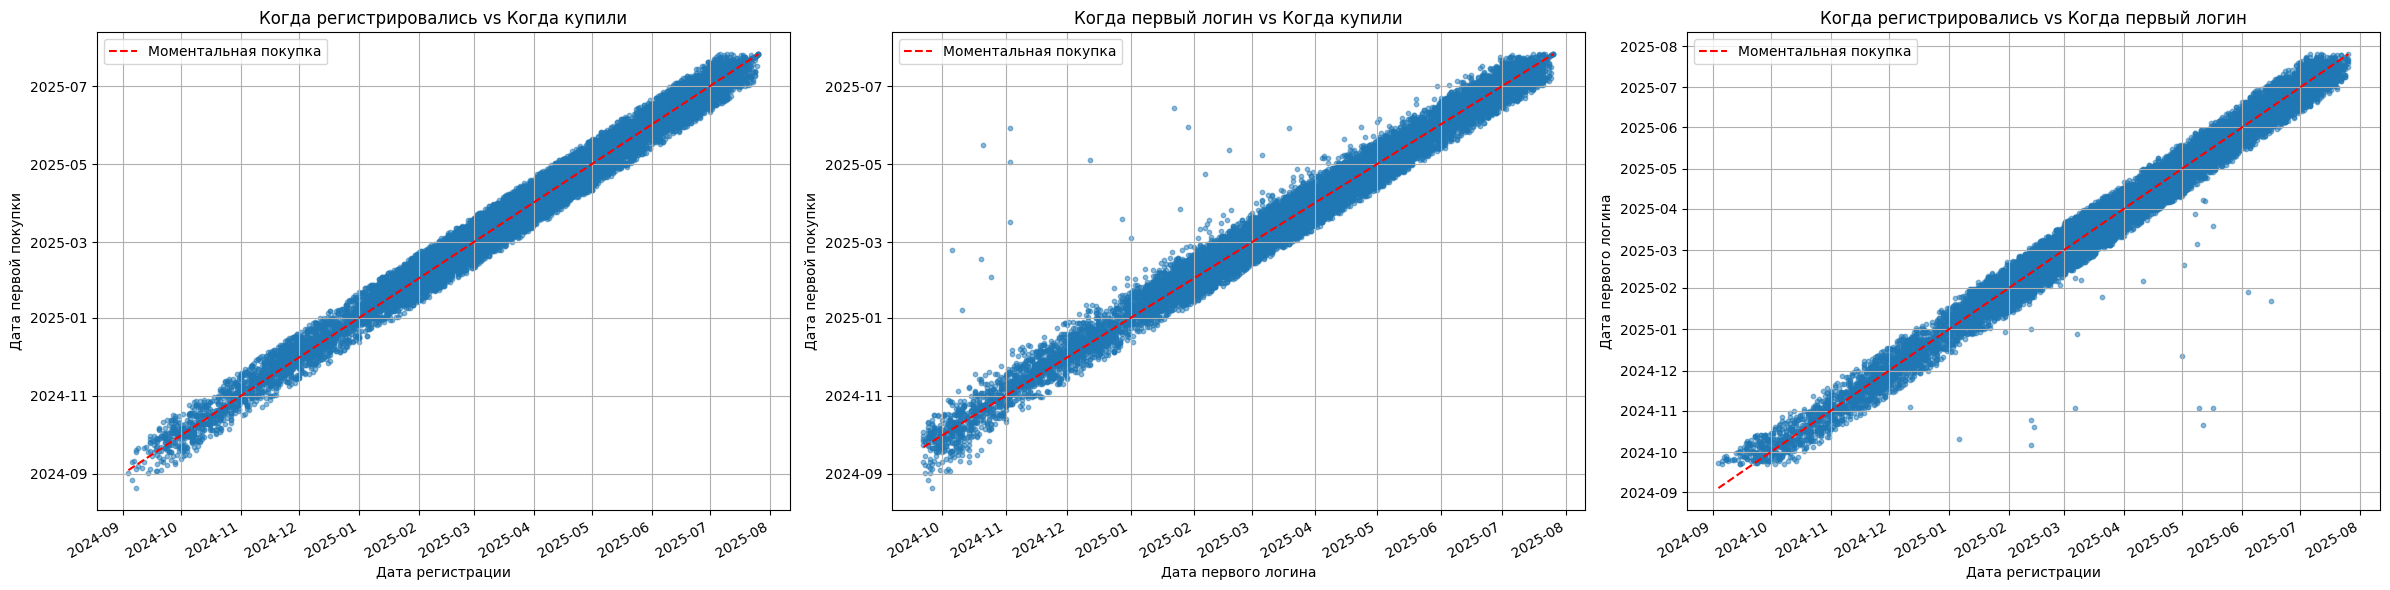

In [13]:
df_enriched = df_q99_filtered.copy()

# Построим для этого графики попарно
fig, axes = plt.subplots(1, 3, figsize=(24, 6))

# --- Первый график ---
# Строим график зависимости дат регистрации и дат первой покупки
axes[0].scatter(df_enriched["reg_dt"], df_enriched["first_buy"], alpha=0.5, s=10)

# Добавляем линию "мгновенной покупки" (где X=Y), чтобы видеть задержку
min_date = df_enriched["reg_dt"].min()
max_date = df_enriched["first_buy"].max()
axes[0].plot(
    [min_date, max_date],
    [min_date, max_date],
    color="red",
    linestyle="--",
    label="Моментальная покупка",
)

axes[0].set_title("Когда регистрировались vs Когда купили")
axes[0].set_xlabel("Дата регистрации")
axes[0].set_ylabel("Дата первой покупки")
axes[0].legend()
axes[0].grid(True)

# --- Второй график ---
# Строим график зависимости дат первого логина и дат первой покупки
axes[1].scatter(df_enriched["first_login"], df_enriched["first_buy"], alpha=0.5, s=10)

# Добавляем линию "мгновенной покупки" (где X=Y), чтобы видеть задержку
min_date = df_enriched["first_login"].min()
max_date = df_enriched["first_buy"].max()
axes[1].plot(
    [min_date, max_date],
    [min_date, max_date],
    color="red",
    linestyle="--",
    label="Моментальная покупка",
)

axes[1].set_title("Когда первый логин vs Когда купили")
axes[1].set_xlabel("Дата первого логина")
axes[1].set_ylabel("Дата первой покупки")
axes[1].legend()
axes[1].grid(True)


# --- Третий график ---
# Строим график зависимости дат регистрации и дат первого логина
axes[2].scatter(df_enriched["reg_dt"], df_enriched["first_login"], alpha=0.5, s=10)

# Добавляем линию "мгновенной покупки" (где X=Y), чтобы видеть задержку
min_date = df_enriched["reg_dt"].min()
max_date = df_enriched["first_login"].max()
axes[2].plot(
    [min_date, max_date],
    [min_date, max_date],
    color="red",
    linestyle="--",
    label="Моментальная покупка",
)

axes[2].set_title("Когда регистрировались vs Когда первый логин")
axes[2].set_xlabel("Дата регистрации")
axes[2].set_ylabel("Дата первого логина")
axes[2].legend()
axes[2].grid(True)


fig.autofmt_xdate()
plt.tight_layout()
plt.show()

Теперь хорошо.

## Выводы

Данные распределены не нормально на уровне доверия 95%. При проверке гипотез будем использовать непараметрические тесты и очистку по 99 процентилю.

# Гипотезы

**Рассмотрим следующие гипотезы:**
 1. Влияние заранее зарегистрировавшихся пользователей (задолго до первого логина/покупки) и пользователей, которые произвели покупку до регистрации
 2. Влияние браузера на прибыльность или на скорость покупки.
 3. Рассмотреть превалирирование определённого браузера/браузеров у юзеров, совершивших больше всего возвратов.
 4. Мульти-платформенные аномалии

Стратегия проверки: Формулируем каждую гипотезу в формате $H_0H_1$. В дальнейшем проверяем каждую гипотезу отдельно уровне доверия 95%.


### Гипотеза №1.1 "Пришел, увидел, подумал, еще подумал, купил"
_Мы предполагаем, что пользователи, принимающие решение о покупке с разной скоростью (период времени между регистрацией и первой покупкой), приносят разную прибыль._   

#### Переформулируем гипотезу в формате H₀H₁:

H₀: Total_buy не различается у групп «быстрых» и «медленных» покупателей. (Медианы групп равны).

H₁: Total_buy различается в зависимости от скорости принятия решения о покупке.

In [14]:
df_enriched_1 = df_q99_filtered.copy()
# 1. Считаем время до покупки в днях
df_enriched_1["time_to_buy"] = (
    df_enriched_1["first_buy"] - df_enriched_1["reg_dt"]
).dt.days

# 2. Находим медиану — это наш порог разделения
threshold = df_enriched_1["time_to_buy"].median()
print(f"Медианное время до покупки: {threshold} дней")

# 3. Присваиваем названия группам
df_enriched_1["buy_speed_group"] = df_enriched_1["time_to_buy"].apply(
    lambda x: "fast_buyers" if x <= threshold else "slow_buyers"
)

# Проверяем размеры групп (должны быть примерно равны)
print(df_enriched_1["buy_speed_group"].value_counts())

Медианное время до покупки: 1.0 дней
buy_speed_group
fast_buyers    8872
slow_buyers    7651
Name: count, dtype: int64


Проверим распределение целевой переменной total_buy (прибыль) на нормальность визуально (гистограмма) и с помощью теста Колмогорова-Смирнова.

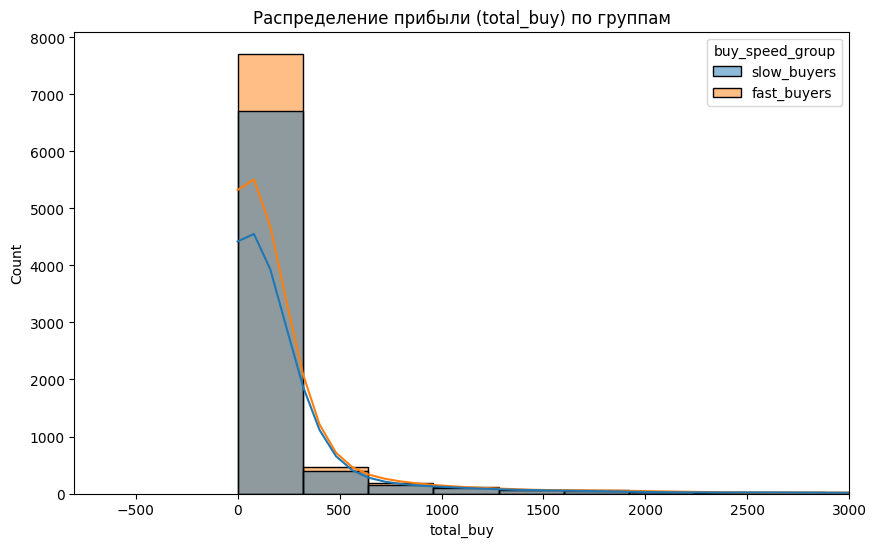

Результаты теста Колмогорова-Смирнова:
----------------------------------------
Группа fast_buyers (n=8872): статистика=0.392, p-value=0.00000e+00
-> Распределение в группе fast_buyers НЕ является нормальным.

Группа slow_buyers (n=7651): статистика=0.399, p-value=0.00000e+00
-> Распределение в группе slow_buyers НЕ является нормальным.



In [37]:
def kstest_check(dataset, col, alpha=0.05):
    """
    Колмогоров-Смирнов. Тест, является ли распределение СВ нормальным
    """
    arr = dataset[col]
    mu = arr.mean()
    sigma = arr.std(ddof=1)
    stat, pvalue = st.kstest(arr, "norm", args=(mu, sigma))

    # Убрали принт внутри, добавили возврат значений
    return stat, pvalue


# --- ВИЗУАЛИЗАЦИЯ ---
plt.figure(figsize=(10, 6))
sns.histplot(
    data=df_enriched_1, x="total_buy", hue="buy_speed_group", kde=True, bins=50
)
plt.title("Распределение прибыли (total_buy) по группам")

plt.xlim(right=3000)
plt.show()

# --- ПРОВЕРКА ПО ГРУППАМ ---
groups = ["fast_buyers", "slow_buyers"]

print("Результаты теста Колмогорова-Смирнова:\n" + "-" * 40)

for group in groups:
    # Фильтруем данные для текущей группы
    group_df = df_enriched_1[df_enriched_1["buy_speed_group"] == group]

    # Теперь функция возвращает значения, и ошибка уйдет
    stat, p_value = kstest_check(group_df, "total_buy")

    print(
        f"Группа {group} (n={len(group_df)}): статистика={stat:.3f}, p-value={p_value:.5e}"
    )

    if p_value < 0.05:
        print(f"-> Распределение в группе {group} НЕ является нормальным.\n")
    else:
        print(f"-> Распределение в группе {group} нормальное.\n")

#### Обоснование выбора критерия:


- Тип переменной: Количественная (total_buy — сумма покупок).

- Количество групп: 2 (сравниваем Быстрых покупателей и Медленных покупателей).

- Зависимость групп: Группы независимы (разные пользователи).

- Распределение: Данные распределены не нормально (подтверждено тестом Колмогорова-Смирнова).

#### Вывод: Используем непараметрический U-критерий Манна-Уитни.

In [16]:
# Выделяем ряды данных (берем полные данные, не сэмпл!)
group_fast = df_enriched_1[df_enriched_1["buy_speed_group"] == "fast_buyers"][
    "total_buy"
]
group_slow = df_enriched_1[df_enriched_1["buy_speed_group"] == "slow_buyers"][
    "total_buy"
]

# Запускаем тест Манна-Уитни
stat, p = st.mannwhitneyu(group_fast, group_slow)

print(f"U-критерий Манна-Уитни: статистика={stat:.0f}, p-value={p}")


# Интерпретация результатов
alpha = 0.05

if p < alpha:
    print("РЕЗУЛЬТАТ: Нулевая гипотеза (H0) ОТВЕРГАЕТСЯ.")
    print("Разница в доходах между группами статистически ЗНАЧИМА.\n")

    # Сравним медианы, чтобы понять направление различий
    median_fast = group_fast.median()
    median_slow = group_slow.median()

    print(f"Медианная прибыль (Быстрые покупатели): {median_fast:.2f}")
    print(f"Медианная прибыль (Медленные покупатели): {median_slow:.2f}")

    diff_percent = (
        ((median_fast - median_slow) / median_slow) * 100 if median_slow != 0 else 0
    )

    if median_fast > median_slow:
        print(f"ВЫВОД: Пользователи, покупающие БЫСТРО, приносят БОЛЬШЕ денег.")
        print(f"Разница в медианах: +{diff_percent:.1f}% в пользу быстрых.")
    else:
        print(
            f"ВЫВОД: Пользователи, которые долго решаются на первую покупку, приносят БОЛЬШЕ денег."
        )
        print(f"Разница в медианах: +{abs(diff_percent):.1f}% в пользу медленных.")

else:
    print("РЕЗУЛЬТАТ: Не удалось отвергнуть нулевую гипотезу (H0).")
    print("Статистически значимых различий в прибыли между группами НЕ обнаружено.")

U-критерий Манна-Уитни: статистика=34783157, p-value=0.005806921841679852
РЕЗУЛЬТАТ: Нулевая гипотеза (H0) ОТВЕРГАЕТСЯ.
Разница в доходах между группами статистически ЗНАЧИМА.

Медианная прибыль (Быстрые покупатели): 42.46
Медианная прибыль (Медленные покупатели): 39.33
ВЫВОД: Пользователи, покупающие БЫСТРО, приносят БОЛЬШЕ денег.
Разница в медианах: +7.9% в пользу быстрых.


Используя непараметрический U-критерий Манна-Уитни для независимых выборок, мы получили следующие результаты:

- P-value: $p < 0.05$.

- Результат: Нулевая гипотеза ($H_0$) отвергается. Различия между группами статистически значимы и не являются случайными.

Быстрые покупатели приносят на 7,9% больше прибыли.

Давайте в качестве развлечения проверим аналогичную гипотезу, но с total_return:
Мы уже разделили пользователей на быстрых и медленных покупателей в прошлом шаге, так что датасет уже готов.

## Гипотеза №1.2: "Я щас как возьму, а потом как верну"


Формулировка:

$H_0$: Объем возвратов (total_return) не отличается между быстрыми и медленными покупателями.

$H_1$: Объем возвратов различается между быстрыми и медленными покупателями.

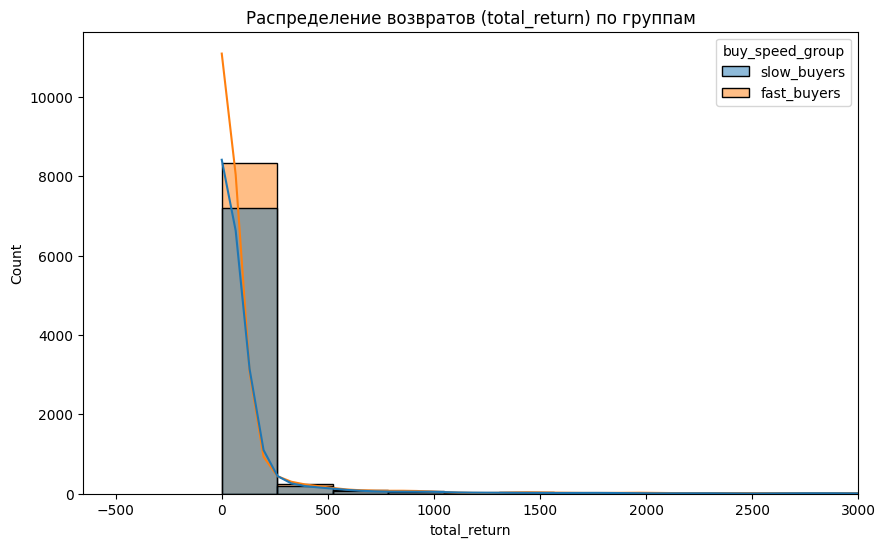

Результаты теста Колмогорова-Смирнова (total_return):
----------------------------------------
Группа fast_buyers: статистика=0.425, p-value=0.00000e+00
Распределение НЕ нормальное.
Группа slow_buyers: статистика=0.432, p-value=0.00000e+00
Распределение НЕ нормальное.
----------------------------------------

U-критерий Манна-Уитни: статистика=33990621, p-value=0.8037385516302802
----------------------------------------
РЕЗУЛЬТАТ: Различий в возвратах НЕТ (H0 принимается).


In [38]:
# Визуализация возвратов (total_return)
plt.figure(figsize=(10, 6))
# Ограничим ось X, так как возвратов обычно меньше, чем покупок, и могут быть выбросы
sns.histplot(
    data=df_enriched_1, x="total_return", hue="buy_speed_group", kde=True, bins=50
)
plt.title("Распределение возвратов (total_return) по группам")
plt.xlim(right=3000)
plt.show()

# Проверка на нормальность (Колмогоров-Смирнов)
groups = ["fast_buyers", "slow_buyers"]
print("Результаты теста Колмогорова-Смирнова (total_return):\n" + "-" * 40)

for group in groups:
    group_df = df_enriched_1[df_enriched_1["buy_speed_group"] == group]
    stat, p_value = kstest_check(group_df, "total_return")

    print(f"Группа {group}: статистика={stat:.3f}, p-value={p_value:.5e}")
    if p_value < 0.05:
        print(f"Распределение НЕ нормальное.")
    else:
        print(f"Распределение нормальное.")
print("-" * 40 + "\n")

# Тест Манна-Уитни (сравнение групп)
group_fast = df_enriched_1[df_enriched_1["buy_speed_group"] == "fast_buyers"][
    "total_return"
]
group_slow = df_enriched_1[df_enriched_1["buy_speed_group"] == "slow_buyers"][
    "total_return"
]

stat, p = st.mannwhitneyu(group_fast, group_slow)

print(f"U-критерий Манна-Уитни: статистика={stat:.0f}, p-value={p}")
print("-" * 40)

if p < 0.05:
    print("РЕЗУЛЬТАТ: Различия в возвратах статистически ЗНАЧИМЫ (H0 отвергается).")

    med_fast = group_fast.median()
    med_slow = group_slow.median()
    mean_fast = (
        group_fast.mean()
    )  # Для возвратов полезно глянуть и среднее, т.к. медиана может быть 0
    mean_slow = group_slow.mean()

    print(f"\nМедиана возвратов (Fast): {med_fast:.2f} (Среднее: {mean_fast:.2f})")
    print(f"Медиана возвратов (Slow): {med_slow:.2f} (Среднее: {mean_slow:.2f})")

    if med_fast > med_slow:
        print("\n 'Быстрые' покупатели возвращают товары БОЛЬШЕ.")
    elif med_slow > med_fast:
        print("\n-'Медленные' покупатели возвращают товары БОЛЬШЕ.")
    else:
        # Если медианы равны (например, обе 0), смотрим на средние
        if mean_fast > mean_slow:
            print("\nМедианы равны, но в среднем 'Быстрые' возвращают больше.")
        else:
            print("\nМедианы равны, но в среднем 'Медленные' возвращают больше.")
else:
    print("РЕЗУЛЬТАТ: Различий в возвратах НЕТ (H0 принимается).")

Статистическое решение

P-value: $p > 0.05$.

Результат: Нулевая гипотеза принимается. Скорость принятия решения о первой покупке (быстро или медленно) не влияет на объем возвратов в будущем.



Быстрые покупатели (те, кто совершает первую покупку вскоре после регистрации) приносят больше прибыли и при этом не отличаются по уровню возвратов от медленных покупателей. Это делает их более ценными для бизнеса.
##Рекомендации для бизнеса:
- Предлагайте "быстрые" триггеры для первой покупки: скидки на первый заказ, бесплатная доставка, ограниченные по времени предложения.
- Минимизируйте шаги между регистрацией и покупкой. Внедрите "быструю покупку" для зарегистрированных пользователей.
- Сразу после регистрации предлагайте персонализированные рекомендации (если есть таргет) или популярные товары, чтобы сократить время на принятие решения.
- Поскольку объем возвратов не отличается между группами, не стоит:
    
    - Опасаться, что ускорение первой покупки приведет к росту возвратов.
    
    - Вводить разные политики возврата для этих сегментов.

### Гипотеза №2 "Различия в выручке на пользователя, возвратах на пользователя и скорости покупки между популярными и непопулярными браузерами"

Рассмотрим популярность браузеров по количеству покупок

In [18]:
browsers_df = (
    df_q99_filtered.groupby("browser").agg(
        count=("browser", "count"),
    )
).sort_values("count", ascending=False)

total = browsers_df["count"].sum()
print("total count", total)

browsers_df.head(8)

total count 16523


,count
browser,
2,5790
3,3926
1,2961
9,992
0,576
4,427
6,396
10,283


Браузеры 2 и 3 выделим в отдельную группу как популярные.

In [19]:
top_browsers = [2, 3]
df_q99_filtered_2 = df_q99_filtered.copy()
df_q99_filtered_2["first_buy_reg_diff"] = (
    df_q99_filtered_2["first_buy"] - df_q99_filtered_2["reg_dt"]
)
df_enriched_top_browsers = df_q99_filtered_2[
    df_q99_filtered_2["browser"].isin(top_browsers)
]
df_enriched_low_browsers = df_q99_filtered_2[
    ~df_q99_filtered_2["browser"].isin(top_browsers)
]

#### 2.1. Влияние популярности браузера на выручку. Переформулируем гипотезу в формате H₀H₁:
$H_0$: Порядок значений выручки на пользователя не отличается в популярных браузерах

$H_1$: Порядок значений выручки на пользователя отличается в популярных браузерах.

Оставим только записи с ненулевой выручкой и рассмотрим нормальность распределений:

In [20]:
top_browsers_non_zero_buy = df_enriched_top_browsers[df_enriched_top_browsers["total_buy"] > 0]
low_browsers_non_zero_buy = df_enriched_low_browsers[df_enriched_low_browsers["total_buy"] > 0]

print("Популярные браузеры:")
shapiro_check(top_browsers_non_zero_buy, "total_buy")

print("Менее популярные браузеры:")
shapiro_check(low_browsers_non_zero_buy, "total_buy")

Популярные браузеры:
Шапиро
Данные total_buy скорее всего распределены не нормально

Менее популярные браузеры:
Шапиро
Данные total_buy скорее всего распределены не нормально



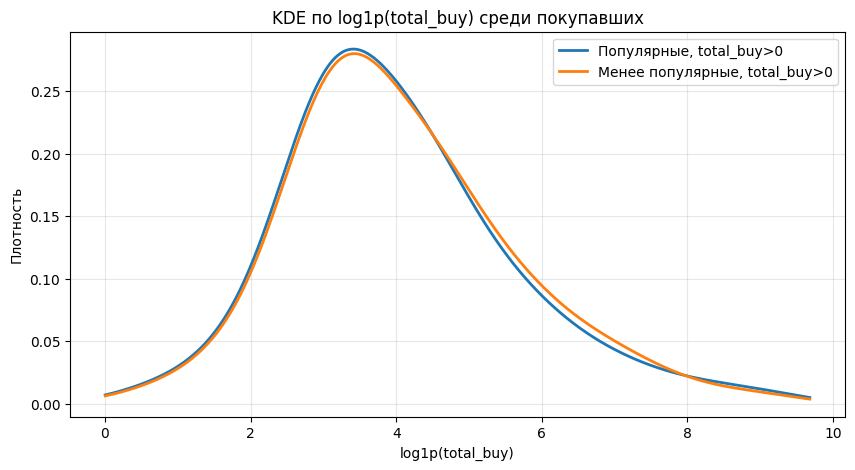

In [21]:
col = "total_buy"

x1 = top_browsers_non_zero_buy[col].dropna().to_numpy()
x2 = low_browsers_non_zero_buy[col].dropna().to_numpy()

x1 = np.log1p(x1)
x2 = np.log1p(x2)

xs = np.linspace(min(x1.min(), x2.min()), max(x1.max(), x2.max()), 600)
k1 = gaussian_kde(x1, bw_method=0.35)
k2 = gaussian_kde(x2, bw_method=0.35)

plt.figure(figsize=(10, 5))
plt.plot(xs, k1(xs), label="Популярные, total_buy>0", linewidth=2)
plt.plot(xs, k2(xs), label="Менее популярные, total_buy>0", linewidth=2)
plt.title("KDE по log1p(total_buy) среди покупавших")
plt.xlabel("log1p(total_buy)")
plt.ylabel("Плотность")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

Тест Шапиро-Уилка показывает, что данные распределены не нормально.
По визуализации видно, что различий нет, но нужно протестировать.

Выручка — количественный показатель, групп по браузерам 2, данные в них независимы и распределены не нормально, значит для проверки гипотезы используем U-критерий Манна-Уитни:

In [22]:
st.mannwhitneyu(
    top_browsers_non_zero_buy["total_buy"],
    low_browsers_non_zero_buy["total_buy"],
)
print(stat, p)

33990621.0 0.8037385516302802


Тест Шапиро–Уилка показал отклонение распределений от нормального, в связи с чем для сравнения групп был использован непараметрический U-критерий Манна–Уитни. Анализ проведён среди пользователей, совершивших покупку (total_buy > 0). Полученное значение p-value (p ≈ 0.80) не позволяет отвергнуть нулевую гипотезу о равенстве распределений. Следовательно, статистически значимых различий в размере выручки между популярными и менее популярными браузерами не обнаружено.

#### 2.2. Влияние популярности браузера на возвраты. Переформулируем гипотезу в формате H₀H₁:
$H_0$: Порядок значений возвратов на пользователя не отличается в популярных браузерах

$H_1$: Порядок значений возвратов на пользователя отличается в популярных браузерах

Оставим только записи с ненулевыми возвратами и рассмотрим нормальность распределений:

In [23]:
top_browsers_non_zero_returns = df_enriched_top_browsers[df_enriched_top_browsers["total_return"] > 0]
low_browsers_non_zero_returns = df_enriched_low_browsers[df_enriched_low_browsers["total_return"] > 0]

print("Популярные браузеры:")
shapiro_check(top_browsers_non_zero_returns, "total_return", n=1000)

print("Менее популярные браузеры:")
shapiro_check(low_browsers_non_zero_returns, "total_return", n=1000)

Популярные браузеры:
Шапиро
Данные total_return скорее всего распределены не нормально

Менее популярные браузеры:
Шапиро
Данные total_return скорее всего распределены не нормально



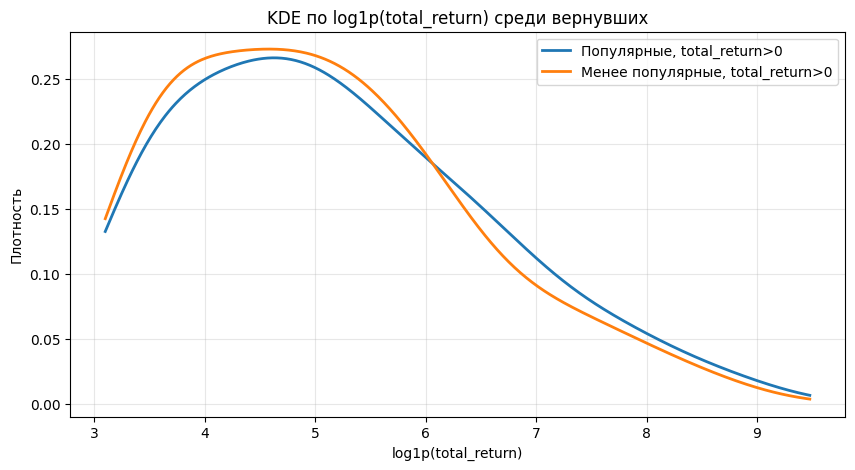

In [24]:
col = "total_return"

x1 = top_browsers_non_zero_returns['total_return'].dropna().to_numpy()
x2 = low_browsers_non_zero_returns['total_return'].dropna().to_numpy()

x1 = np.log1p(x1)
x2 = np.log1p(x2)

xs = np.linspace(min(x1.min(), x2.min()), max(x1.max(), x2.max()), 600)
k1 = gaussian_kde(x1, bw_method=0.35)
k2 = gaussian_kde(x2, bw_method=0.35)

plt.figure(figsize=(10, 5))
plt.plot(xs, k1(xs), label="Популярные, total_return>0", linewidth=2)
plt.plot(xs, k2(xs), label="Менее популярные, total_return>0", linewidth=2)
plt.title("KDE по log1p(total_return) среди вернувших")
plt.xlabel("log1p(total_return)")
plt.ylabel("Плотность")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

Тест Шапиро-Уилка показывает, что данные распределены не нормально. По визуализации видны некоторые различия.
Возвраты — количественный показатель, групп по браузерам 2, данные в них независимы и распределены ненормально, значит для проверки гипотезы используем U-критерий Манна-Уитни:

In [25]:
stat, p = st.mannwhitneyu(
    top_browsers_non_zero_returns["total_return"], low_browsers_non_zero_returns["total_return"]
)
print(stat, p)

1140558.0 0.04242133790381652


p-value меньше 0.05, U-критерий Манна-Уитни отвергает гипотезу $H_0$ и показывает, что среди пользователей, совершивших возвраты, распределение величины возвратов статистически значимо отличается между популярными и менее популярными браузерами.

#### 2.3. Влияние браузера на скорость покупки. Переформулируем гипотезу в формате H₀H₁:
$H_0$: Порядок значений скорости покупки пользователями не отличается в популярных браузерах.

$H_1$: Порядок значений скорости покупки пользователями отличается в популярных браузерах.

Рассмотрим распределение скорости покупки:


In [26]:
# оставим только валидные данные, где срок первой покупки не отрицательный
df_enriched_top_browsers = df_enriched_top_browsers[df_enriched_top_browsers['first_buy_reg_diff'] > pd.Timedelta(0)]
df_enriched_low_browsers = df_enriched_low_browsers[df_enriched_low_browsers['first_buy_reg_diff'] > pd.Timedelta(0)]

print("Популярные браузеры:")
shapiro_check(df_enriched_top_browsers, "first_buy_reg_diff")

print("Менее популярные браузеры:")
shapiro_check(df_enriched_low_browsers, "first_buy_reg_diff")

Популярные браузеры:
Шапиро
Данные first_buy_reg_diff скорее всего распределены не нормально

Менее популярные браузеры:
Шапиро
Данные first_buy_reg_diff скорее всего распределены не нормально



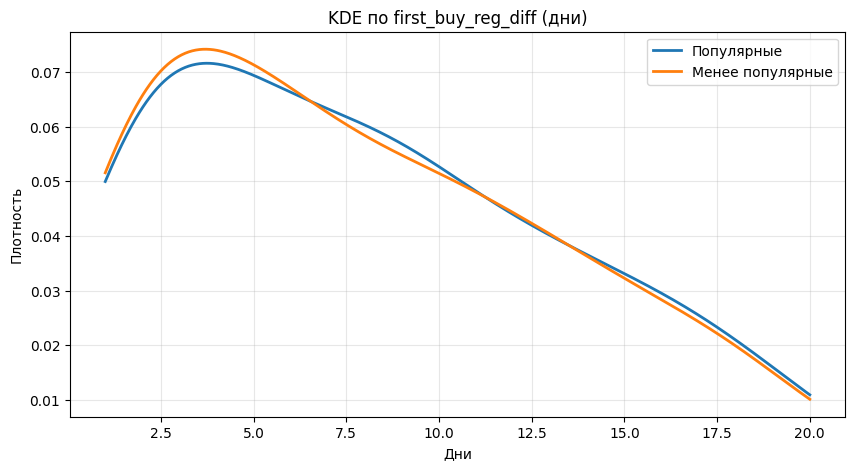

In [27]:
col = "first_buy_reg_diff"

x1 = df_enriched_top_browsers["first_buy_reg_diff"].dropna()
x2 = df_enriched_low_browsers["first_buy_reg_diff"].dropna()

# timedelta -> float (дни)
x1 = x1.dt.total_seconds().to_numpy() / 86400
x2 = x2.dt.total_seconds().to_numpy() / 86400

xs = np.linspace(min(x1.min(), x2.min()), max(x1.max(), x2.max()), 600)

k1 = gaussian_kde(x1, bw_method=0.35)
k2 = gaussian_kde(x2, bw_method=0.35)

plt.figure(figsize=(10, 5))
plt.plot(xs, k1(xs), label="Популярные", linewidth=2)
plt.plot(xs, k2(xs), label="Менее популярные", linewidth=2)
plt.title("KDE по first_buy_reg_diff (дни)")
plt.xlabel("Дни")
plt.ylabel("Плотность")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

По визуализации видны небольшие отличия.

Данные распределены не нормально, аналогично предыдущему пункту используем U-критерий Манна-Уитни:

In [28]:
stat, p = st.mannwhitneyu(
    df_enriched_top_browsers["first_buy_reg_diff"],
    df_enriched_low_browsers["first_buy_reg_diff"],
)
print(stat, p)

8727394.0 0.22304504914304013


Распределение времени до первой покупки после регистрации (first_buy_reg_diff) отличается от нормального, в связи с чем для сравнения групп был использован U-критерий Манна–Уитни. Визуальный анализ распределений и результаты статистического теста (p ≈ 0.22) не выявили статистически значимых различий между пользователями популярных и менее популярных браузеров. Следовательно, тип браузера не оказывает влияния на скорость совершения первой покупки.

## Гипотеза №3 "Браузерные войны!"
_Предпочтения браузера у юзеров, совершивших больше всего покупок/возвратов._

Рассмотрим корреляцию используемых браузеров юзерами.

### Переформулируем гипотезу в формате $H_0H_1$:

$H_0$: Количество покупок имеет идентичные медианы по браузерам.

$H_1$: Количество покупок имеет различные медианы по браузерам.

Выбор критерия

**Шаг 1**: Какой тип переменной сравниваем?
- Количественная (числовая)

**Шаг 2**: Сколько групп сравнивается?
- \>2 групп.

**Шаг 3**: Группы зависимы или независимы?
- Независимые группы: сравниваются разные пользователи в одно и то же время.

**Шаг 4**: Есть ли нормальность распределения?

Для количественных переменных проверяем нормальность (например, с помощью теста Шапиро-Уилка или визуально).

**Шаг 5**: Выбор критерия

Критерий Краскела-Уоллиса

In [29]:
def kruskal_statistic(args):
    """
    Критерий Краскела-Уоллиса
    """
    h_statistic, p_value = st.kruskal(*args)

    result = "На уровне значимости 0.05 "
    if p_value < 0.05:
        result += "нулевая гипотеза отвергается. Есть значимые различия между группами."
    else:
        result += (
            "нулевая гипотеза НЕ отвергается. Нет значимых различий между группами."
        )
    return result


print("Группировка первых покупок по браузерам и дням")
df_enriched_3 = df_q99_filtered.copy()

df_enriched_3 = df_enriched_3.groupby(["first_buy", "browser"]).agg(
    purchase_count=("total_buy", "count")
)

df_enriched_3 = df_enriched_3.reset_index()

display(df_enriched_3.head())
shapiro_check(df_enriched_3, "purchase_count", n=None)
kstest_check(df_enriched_3, "purchase_count")


def df_browsers_array(dataset):
    """
    Собираем количество покупок в массив для сравнения
    """
    result = []
    for browser_n in dataset["browser"].unique():
        df_browsers_n = dataset.loc[dataset["browser"] == browser_n]
        df_browsers_n = df_browsers_n.reset_index(drop=True)
        if len(df_browsers_n["browser"].unique()) > 1:
            shapiro_check(df_browsers_n, "purchase_count", n=None)
            kstest_check(df_browsers, "purchase_count")
        result.append(df_browsers_n["purchase_count"].values)
    return result


kruskal_statistic(df_browsers_array(df_enriched_3))

Группировка первых покупок по браузерам и дням


,first_buy,browser,purchase_count
0,2024-08-21,1,1
1,2024-08-27,9,1
2,2024-09-02,1,1
3,2024-09-02,3,1
4,2024-09-03,1,1


Шапиро
Данные purchase_count скорее всего распределены не нормально



'На уровне значимости 0.05 нулевая гипотеза отвергается. Есть значимые различия между группами.'

### Гипотеза №3.1
_Среднее количество покупок на популярных браузерах отличается от неполулярных._

#### Переформулируем гипотезу в формате $H_0H_1$:

$H_0$: Среднее количество покупок на N популярных браузерах статистически значимо НЕ отличается от кол-ва покупок на остальных.

$H_1$: Среднее количество покупок на N популярных браузерах статистически значимо отличается от кол-ва покупок на остальных.

Выбор критерия

**Шаг 1**: Какой тип переменной сравниваем?
- Количественная (числовая)

**Шаг 2**: Сколько групп сравнивается?
- 2 группы.

**Шаг 3**: Группы зависимы или независимы?
- Независимые группы: сравниваются разные пользователи в одно и то же время.

**Шаг 4**: Есть ли нормальность распределения?
Нет

**Шаг 5**: Выбор критерия
U-критерий Манна — Уитни

In [30]:
def mannwhitneyu_statistic(args):
    """
    Критерий Манна-Уитни
    """
    h_statistic, p_value = st.mannwhitneyu(*args)

    result = f"Для {N} браузеров на уровне значимости 0.01 "
    if p_value < 0.01:
        result += f"отвергается нулевая гипотеза. \nСреднее количество покупок на {N} популярных браузерах статистически значимо отличается от кол-ва покупок на остальных.\n\n"
    else:
        result += f"принимается нулевая гипотеза. \nСреднее количество покупок на {N} популярных браузерах статистически значимо НЕ отличается от кол-ва покупок на остальных.\n\n"
    return result


for N in [1, 2, 3]:
    df_enriched_3_1 = df_enriched_3.copy()
    top_browsers = (
        df_enriched_3_1[["browser", "purchase_count"]]
        .groupby("browser")
        .sum()
        .nlargest(n=N, columns="purchase_count", keep="last")
        .index.values
    )
    df_top_browsers = df_enriched_3_1[df_enriched_3_1["browser"].isin(top_browsers)][
        ["first_buy", "purchase_count"]
    ]
    df_other_browsers = df_enriched_3_1[~df_enriched_3_1["browser"].isin(top_browsers)][
        ["first_buy", "purchase_count"]
    ]

    df_enriched_3_1 = (
        df_top_browsers.merge(
            df_other_browsers, how="outer", on="first_buy", suffixes=("_top", "_other")
        )
        .fillna(0)
        .groupby("first_buy")
        .sum()
    )

    print(
        mannwhitneyu_statistic(
            [
                df_enriched_3_1["purchase_count_top"].values,
                df_enriched_3_1["purchase_count_other"].values,
            ]
        )
    )

Для 1 браузеров на уровне значимости 0.01 отвергается нулевая гипотеза. 
Среднее количество покупок на 1 популярных браузерах статистически значимо отличается от кол-ва покупок на остальных.


Для 2 браузеров на уровне значимости 0.01 отвергается нулевая гипотеза. 
Среднее количество покупок на 2 популярных браузерах статистически значимо отличается от кол-ва покупок на остальных.


Для 3 браузеров на уровне значимости 0.01 отвергается нулевая гипотеза. 
Среднее количество покупок на 3 популярных браузерах статистически значимо отличается от кол-ва покупок на остальных.




#### Вывод:

Можем заметить, что для $N = 1$ уже видим статистически значимые отличия, то есть мы имеем один браузер, значимо превышающий остальные по количеству покупок.

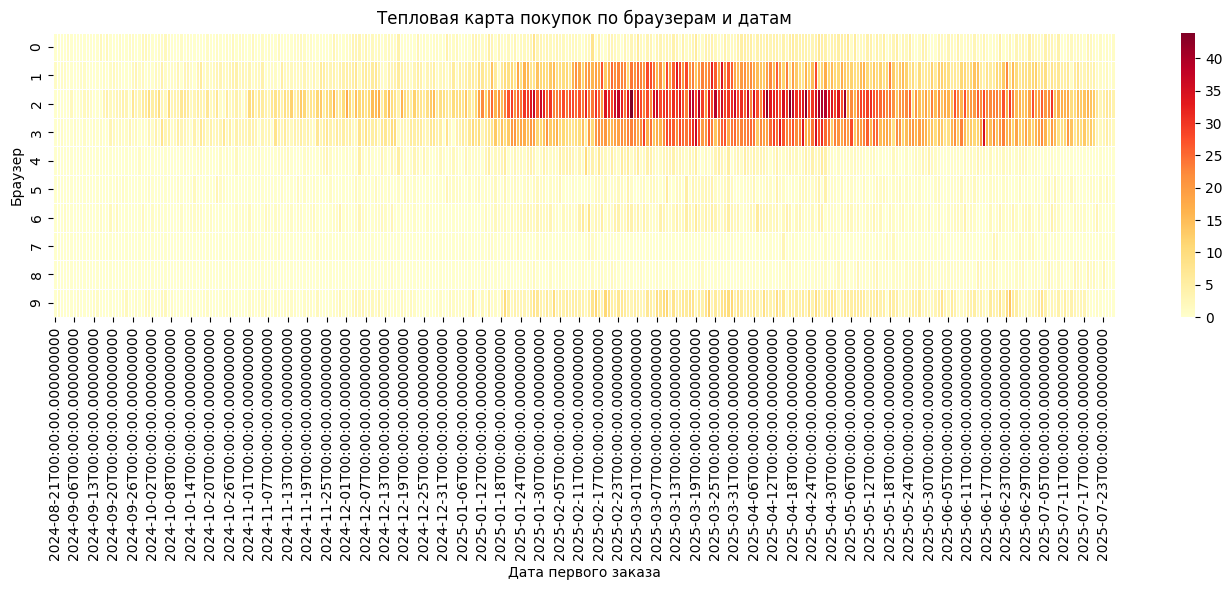

In [31]:
heatmap_df = df_enriched_3[df_enriched_3["browser"] < 10].pivot_table(
    index="browser",
    columns="first_buy",
    values="purchase_count",
    aggfunc="sum",
    fill_value=0,
)
plt.figure(figsize=(14, 6))

sns.heatmap(heatmap_df, cmap="YlOrRd", linewidths=0.5)

plt.xlabel("Дата первого заказа")
plt.ylabel("Браузер")
plt.title("Тепловая карта покупок по браузерам и датам")

plt.tight_layout()
plt.show()

_По тепловой карте видим, что лидирующий браузер по количеству покупок - браузер с идентификатором **2**._

## Гипотеза №4 Этап формулирования гипотезы

Для формулирования гипотезы построим график покупок/возвратов относительно даты первого логина.    
Этот график не покажет точные даты покупок, так как суммы Покупкок и Возвратов каждого клиента будут приложены к дате его первого логина.   

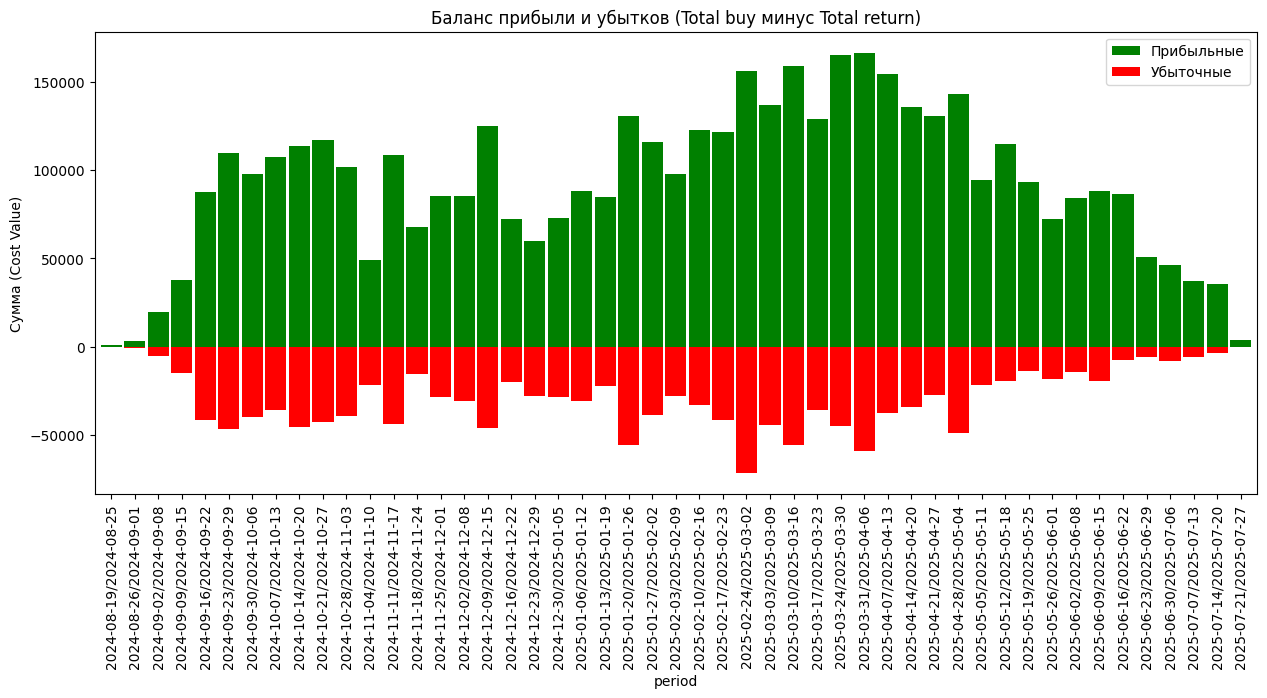

In [32]:
# Подготовка данных
df_enriched_4 = df_q99_filtered.copy()

df_enriched_4["period"] = df_enriched_4["first_buy"].dt.to_period("W")

profit_series = df_enriched_4.groupby("period")["total_buy"].sum()
loss_series = df_enriched_4.groupby("period")["total_return"].sum() * -1

plot_data = pd.DataFrame(
    {"Прибыльные": profit_series, "Убыточные": loss_series}
).fillna(0)


# График 1
ax = plot_data.plot(
    kind="bar", stacked=True, color=["green", "red"], width=0.9, figsize=(15, 6)
)
ax.set_title("Баланс прибыли и убытков (Total buy минус Total return)")
ax.set_ylabel("Сумма (Cost Value)")


plt.show()

Согласно данного графика видно, что достаточное количество людей и покупают и возвращают товары.   
Посмотрим на них в разрезе максимально "убыточных" клиентов (тех, кто возвращает товаров больше, чем покупает).   
Построим точечное распределение пользователей в зависимости от их разницы между покупками  и возвратами (введём как Cost Value).

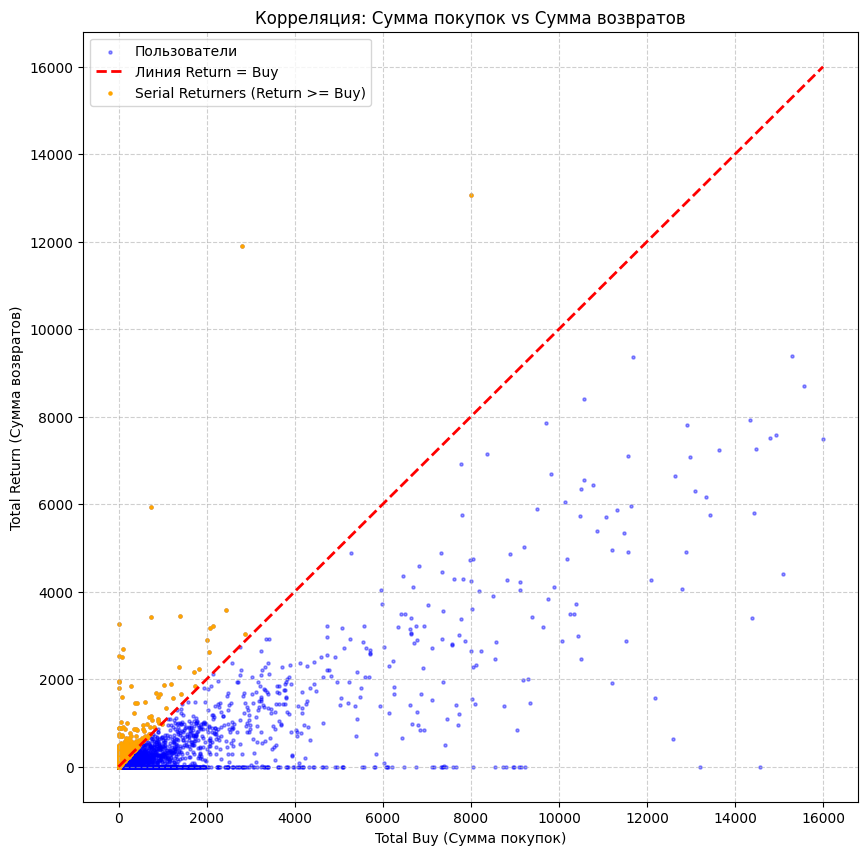

Найдено 1848 пользователей, у которых Сумма возвратов >= Сумма покупок.

Топ-10 таких пользователей по сумме убытка:


,platform_num,first_login,reg_dt,browser,first_buy,target,total_buy,total_return,period,cost_value
user_id,,,,,,,,,,
13991,86,2025-04-26,2025-04-29,5,2025-05-03,0.000000,2794.478885,11899.5820,2025-04-28/2025-05-04,-9105.103115
14345,10,2024-12-27,2024-12-07,1,2024-12-23,0.000000,741.981698,5929.6333,2024-12-23/2024-12-29,-5187.651602
20193,4,2025-03-02,2025-02-19,2,2025-02-26,-3.428557,8003.467423,13067.9560,2025-02-24/2025-03-02,-5064.488577
4510,2,2025-05-07,2025-04-26,9,2025-05-06,0.000000,0.000000,3272.0193,2025-05-05/2025-05-11,-3272.019300
3007,5,2025-03-27,2025-03-22,2,2025-04-04,0.000000,731.287571,3425.5160,2025-03-31/2025-04-06,-2694.228429
17376,6,2024-09-25,2024-09-22,2,2024-09-30,0.000000,98.443918,2700.0000,2024-09-30/2024-10-06,-2601.556082
14712,2,2025-03-25,2025-03-25,5,2025-03-22,0.000000,0.000000,2535.8235,2025-03-17/2025-03-23,-2535.823500
1336,10,2025-02-16,2025-02-25,2,2025-02-20,-3.428557,83.818498,2500.0000,2025-02-17/2025-02-23,-2416.181502
2291,58,2024-10-14,2024-10-09,1,2024-10-16,0.000000,1398.518933,3450.2950,2024-10-14/2024-10-20,-2051.776067


In [33]:
# Обогащение данных
df_enriched_4["cost_value"] = df_enriched_4["total_buy"] - df_enriched_4["total_return"]

# Построение графика
plt.figure(figsize=(10, 10))
plt.scatter(
    df_enriched_4["total_buy"],
    df_enriched_4["total_return"],
    alpha=0.4,
    s=5,
    c="blue",
    label="Пользователи",
)

# Линия безубыточности (Y = X)
# Если точка на линии, значит клиент вернул всё, что купил (Cost value = 0)
# Если выше линии - вернул больше, чем купил (Cost value < 0) - Аномалия
max_val = max(df_enriched_4["total_buy"].max(), df_enriched_4["total_return"].max())
plt.plot(
    [0, max_val],
    [0, max_val],
    color="red",
    linestyle="--",
    linewidth=2,
    label="Линия Return = Buy",
)

plt.title("Корреляция: Сумма покупок vs Сумма возвратов")
plt.xlabel("Total Buy (Сумма покупок)")
plt.ylabel("Total Return (Сумма возвратов)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)


# Клиенты, у которых возвратов больше, чем покупок или равенство
serial_returners = df_enriched_4[
    df_enriched_4["total_return"] >= df_enriched_4["total_buy"]
]

plt.scatter(
    serial_returners["total_buy"],
    serial_returners["total_return"],
    color="orange",
    s=5,
    label="Serial Returners (Return >= Buy)",
)
plt.legend()

plt.show()

# Вывод статистики по "Серийным возвращенцам"
print(
    f"Найдено {len(serial_returners)} пользователей, у которых Сумма возвратов >= Сумма покупок."
)
print("\nТоп-10 таких пользователей по сумме убытка:")
display(serial_returners.sort_values("cost_value").head(10))

Замечено любопытный момент, в Топ-10 таких пользователей довольно много имеют значительные цифры в platform_num (количество платформ, с которых они заходили. Сформулирую окончательную гипотезу.)

### Гипотеза №4 "Мульти-платформенные аномалии"
_Проверка связи между количеством использованных платформ и убыточностью клиента._

При визуальном анализе пользователей, у которых сумма возвратов превышает сумму покупок было замечено, что многие из них имеют аномально высокое количество уникальных платформ (platform_num), с которых осуществлялся вход. В то время как обычный пользователь использует 1-3 устройства (телефон, ноутбук, планшет), некоторые "убыточные" клиенты имеют десятки входов с разных платформ, что может указывать на бот-фермы.

### Сформируем гипотезу в формате $H_0H_1$:
$H_0$: Медианное количество платформ (platform_num) у убыточных клиентов (serial_returners) не отличается от медианного количества платформ у прибыльных клиентов. Различия случайны.

$H_1$: Медианное количество платформ у убыточных клиентов статистически значимо выше, чем у прибыльных.

Построение нулевой и альтернативной гипотез.   
● Выбор уровня значимости:   _0,05_   
● Сбор данных для проверки гипотезы: _Тип клиента (доходный/убыточный, если отношение возврата к общей сумме больше 30%)._  
● Выбор статистического теста.   
● Проведение статистического теста, вычисление p-value.   
● Сравнение p-value c уровнем значимости и вывод, отклонить или не отклонить нулевую гипотезу.   

Алгоритм выбора критерия   
Шаг 1: Какой тип переменной сравниваем?   
● Количественная дискретная (platform_num).

Шаг 2: Сколько групп сравнивается?   
● 2 группы.

Шаг 3: Группы зависимы или независимы?   
● Независимые группы: Данные по разным пользователям.   

Шаг 4: Есть ли нормальность распределения?   
Распределение количества платформ, скорее всего, ненормальное (скошено вправо, "длинный хвост"). Проверим это отдельно.

Выбранный метод: **U-критерий Манна-Уитни**

Количество убыточных клиентов: 2159
Количество прибыльных клиентов: 14364

Медиана платформ (Убыточные): 4.0
Медиана платформ (Прибыльные): 2.0
Среднее платформ (Убыточные):  9.76
Среднее платформ (Прибыльные): 4.70


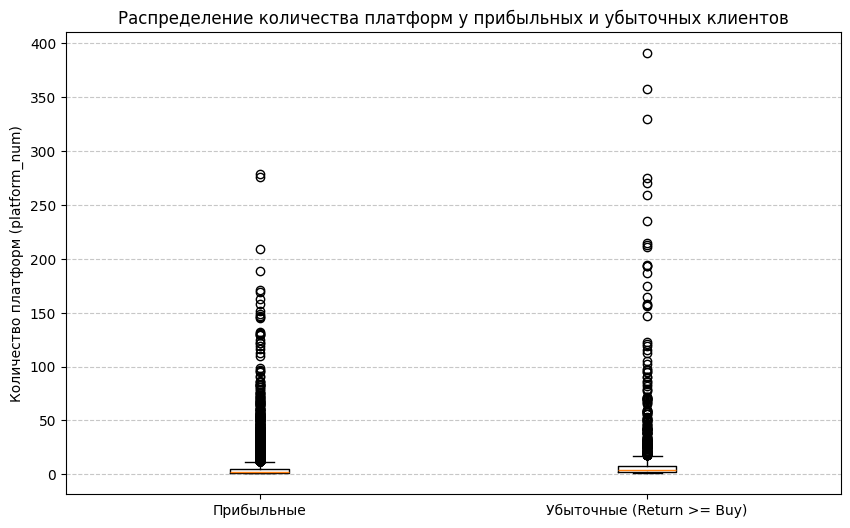

Статистика U: 19770604.0
P-value: 0.000

ВЫВОД: Отклоняем H0. Различия статистически значимы.
Убыточные клиенты используют значимо больше платформ, чем нормальные пользователи.
Это подтверждает гипотезу о технической природе убытков.


In [34]:
# Сегментация пользователей
# "Серийные возвращенцы" (убыточные клиенты) возвращают более 30% товаров.
serial_returners_mask = (
    df_enriched_4["total_return"]
    / (df_enriched_4["total_buy"] + df_enriched_4["total_return"])
    > 0.3
)
group_loss = df_enriched_4[serial_returners_mask]["platform_num"]

# "Нормальные" (прибыльные)
group_profit = df_enriched_4[~serial_returners_mask]["platform_num"]

# Текстовый вывод
print(f"Количество убыточных клиентов: {len(group_loss)}")
print(f"Количество прибыльных клиентов: {len(group_profit)}")
print(f"\nМедиана платформ (Убыточные): {group_loss.median()}")
print(f"Медиана платформ (Прибыльные): {group_profit.median()}")
print(f"Среднее платформ (Убыточные):  {group_loss.mean():.2f}")
print(f"Среднее платформ (Прибыльные): {group_profit.mean():.2f}")

# Визуализация распределений
plt.figure(figsize=(10, 6))
plt.boxplot(
    [group_profit, group_loss], tick_labels=["Прибыльные", "Убыточные (Return >= Buy)"]
)
plt.title("Распределение количества платформ у прибыльных и убыточных клиентов")
plt.ylabel("Количество платформ (platform_num)")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# Проверка гипотезы (Манна-Уитни)
stat, p_value = st.mannwhitneyu(group_loss, group_profit, alternative="greater")
print(f"Статистика U: {stat}")
print(f"P-value: {p_value:.3f}")

# Вывод
alpha = 0.05
if p_value < alpha:
    print("\nВЫВОД: Отклоняем H0. Различия статистически значимы.")
    print(
        "Убыточные клиенты используют значимо больше платформ, чем нормальные пользователи."
    )
    print("Это подтверждает гипотезу о технической природе убытков.")
else:
    print(
        "\nВЫВОД: Не можем отклонить H0. Связи между убыточностью и количеством платформ не найдено."
    )

**Развернутый вывод по Гипотезе №4:**

Статистический анализ подтвердил предположение, возникшее при визуализации данных. Группа пользователей, генерирующая чистый убыток для компании, характеризуется аномальным поведением в техническом плане.

Медианное и среднее количество платформ, с которых заходили эти пользователи, статистически значимо выше, чем у добросовестных покупателей (p < 0.05).    
Наличие более "длинного хвоста" выбросов (пользователи с десятками платформ) именно в убыточном сегменте может свидетельствовать о работе автоматизированных скриптов (ботов).

**Рекомендация:**
1.  Рассмотреть user_id с platform_num > 50 отдельно. Это не похоже на поведение живых людей.
2.  Помечать аккаунт с platform_num > 10 как подозрительный.

In [39]:
def plot_date_scatter(group):
    """
    Генерирует scatter plot для дат (регистрация vs покупка и т.д.)
    """
    fig, axes = plt.subplots(1, 3, figsize=(24, 6))

    axes[0].scatter(df_enriched["reg_dt"], df_enriched["first_buy"], alpha=0.5, s=10)
    min_date = df_enriched["reg_dt"].min()
    max_date = df_enriched["first_buy"].max()
    axes[0].plot([min_date, max_date], [min_date, max_date], color="red", linestyle="--", label="Моментальная покупка")
    axes[0].set_title("Регистрация vs Покупка")
    axes[0].set_xlabel("Дата регистрации")
    axes[0].set_ylabel("Дата первой покупки")
    axes[0].legend()
    axes[0].grid(True)

    axes[1].scatter(df_enriched["first_login"], df_enriched["first_buy"], alpha=0.5, s=10)
    min_date = df_enriched["first_login"].min()
    max_date = df_enriched["first_buy"].max()
    axes[1].plot([min_date, max_date], [min_date, max_date], color="red", linestyle="--", label="Моментальная покупка")
    axes[1].set_title("Первый логин vs Покупка")
    axes[1].set_xlabel("Дата первого логина")
    axes[1].set_ylabel("Дата первой покупки")
    axes[1].legend()
    axes[1].grid(True)

    axes[2].scatter(df_enriched["reg_dt"], df_enriched["first_login"], alpha=0.5, s=10)
    min_date = df_enriched["reg_dt"].min()
    max_date = df_enriched["first_login"].max()
    axes[2].plot([min_date, max_date], [min_date, max_date], color="red", linestyle="--", label="Моментальная покупка")
    axes[2].set_title("Регистрация vs Первый логин")
    axes[2].set_xlabel("Дата регистрации")
    axes[2].set_ylabel("Дата первого логина")
    axes[2].legend()
    axes[2].grid(True)

    fig.autofmt_xdate()
    plt.tight_layout()
    return fig

def plot_buy_histogram(speed_group):
    """
    Гистограмма total_buy по группам скорости покупки
    """
    fig = plt.figure(figsize=(10, 6))
    if speed_group == "Все":
        sns.histplot(data=df_enriched_1, x="total_buy", hue="buy_speed_group", kde=True, bins=50)
    else:
        filtered = df_enriched_1[df_enriched_1["buy_speed_group"] == speed_group]
        sns.histplot(data=filtered, x="total_buy", kde=True, bins=50)
    plt.title(f"Распределение прибыли (total_buy) для {speed_group}")
    plt.xlim(right=3000)
    return fig

def plot_browser_heatmap():
    """
    Тепловая карта покупок по браузерам
    """
    heatmap_df = df_enriched_3[df_enriched_3["browser"] < 10].pivot_table(
        index="browser",
        columns="first_buy",
        values="purchase_count",
        aggfunc="sum",
        fill_value=0,
    )
    fig = plt.figure(figsize=(14, 6))
    sns.heatmap(heatmap_df, cmap="YlOrRd", linewidths=0.5)
    plt.xlabel("Дата первого заказа")
    plt.ylabel("Браузер")
    plt.title("Тепловая карта покупок по браузерам и датам")
    return fig

def plot_platform_boxplot():
    """
    Boxplot платформ для прибыльных/убыточных
    """
    serial_returners_mask = (df_enriched_4["total_return"] / (df_enriched_4["total_buy"] + df_enriched_4["total_return"]) > 0.3)
    group_loss = df_enriched_4[serial_returners_mask]["platform_num"]
    group_profit = df_enriched_4[~serial_returners_mask]["platform_num"]

    fig = plt.figure(figsize=(10, 6))
    plt.boxplot([group_profit, group_loss], labels=["Прибыльные", "Убыточные"])
    plt.title("Распределение количества платформ")
    plt.ylabel("Количество платформ")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    return fig

def get_summary_stats(browser_id):
    """
    Таблица сводных статистик по браузеру
    """
    if browser_id == "Все":
        stats = df_enriched.describe().to_html()
    else:
        filtered = df_enriched[df_enriched["browser"] == int(browser_id)]
        stats = filtered.describe().to_html()
    return stats

with gr.Blocks(title="Marketplace Data Dashboard") as dashboard:
    gr.Markdown("# Дашборд анализа данных Marketplace")
    gr.Markdown("Интерактивный дашборд для визуализации ключевых инсайтов из анализа данных.")

    with gr.Tab("Дата-анализ"):
        plot_dates = gr.Plot(label="Scatter plots дат")
        btn_dates = gr.Button("Показать scatter plots дат")
        btn_dates.click(plot_date_scatter, inputs=None, outputs=plot_dates)

    with gr.Tab("Распределения покупок"):
        speed_dropdown = gr.Dropdown(choices=["Все", "fast_buyers", "slow_buyers"], label="Группа по скорости покупки")
        plot_buy = gr.Plot(label="Гистограмма total_buy")
        btn_buy = gr.Button("Показать гистограмму")
        btn_buy.click(plot_buy_histogram, inputs=speed_dropdown, outputs=plot_buy)

    with gr.Tab("Браузеры"):
        plot_heatmap = gr.Plot(label="Heatmap браузеров")
        btn_heatmap = gr.Button("Показать heatmap")
        btn_heatmap.click(plot_browser_heatmap, inputs=None, outputs=plot_heatmap)

        browser_dropdown = gr.Dropdown(choices=["Все"] + list(df_enriched["browser"].unique()), label="Выберите браузер")
        stats_table = gr.HTML(label="Сводная статистика")
        btn_stats = gr.Button("Показать статистику")
        btn_stats.click(get_summary_stats, inputs=browser_dropdown, outputs=stats_table)

    with gr.Tab("Платформы и убытки"):
        plot_box = gr.Plot(label="Boxplot платформ")
        btn_box = gr.Button("Показать boxplot")
        btn_box.click(plot_platform_boxplot, inputs=None, outputs=plot_box)

if __name__ == "__main__":
    dashboard.launch(share=True)

/usr/local/lib/python3.12/dist-packages/gradio/utils.py:1052: UserWarning: Expected 1 arguments for function <function plot_date_scatter at 0x7dd9577bd080>, received 0.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/gradio/utils.py:1056: UserWarning: Expected at least 1 arguments for function <function plot_date_scatter at 0x7dd9577bd080>, received 0.
  warnings.warn(


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://6833b629486a0c7124.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
